<a href="https://colab.research.google.com/github/zzeeddd95/capstone-project/blob/master/LSTMApple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**This is a recurrent neural network, specifically an LSTM network designed to predict Apple stock prices one day in advance. **


In [ ]:
#import libraries

import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.layers import Dropout
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal
Using TensorFlow backend.


In [ ]:
#Get Apple stock
applestock = web.DataReader('AAPL', data_source='yahoo', start='2010-05-27', end='2020-05-27')
applestock

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-05-27,36.270000,35.587143,35.799999,36.192856,166570600.0,31.332062
2010-05-28,37.057144,36.192856,37.055714,36.697144,203903700.0,31.768623
2010-06-01,37.991428,36.994286,37.098572,37.261429,219118200.0,32.257130
2010-06-02,37.828571,37.189999,37.791428,37.707142,172137000.0,32.642975
2010-06-03,37.935715,37.201427,37.882858,37.588570,162526700.0,32.540325
...,...,...,...,...,...,...
2020-05-20,319.519989,316.519989,316.679993,319.230011,27876200.0,319.230011
2020-05-21,320.890015,315.869995,318.660004,316.850006,25672200.0,316.850006
2020-05-22,319.230011,315.350006,315.769989,318.890015,20450800.0,318.890015


In [ ]:
#Get dataset information
applestock.shape

(2517, 6)

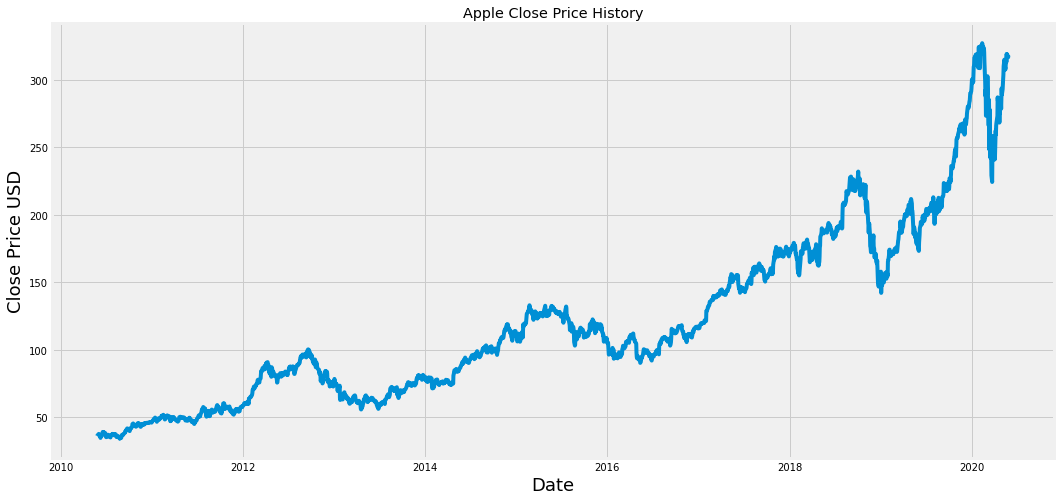

In [ ]:
#visualize closing apple price
plt.figure(figsize=(16,8))
plt.title('Apple Close Price History')
plt.plot(applestock['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD', fontsize=18)
plt.show()

**In this next line of code, we will extract the apple closing price from the stock dataframe, convert it to a numpy array and create a training dataframe consisiting of 80% of closing stock prices.**

In [ ]:
#extract closing price and position into new datafram
appleclose = applestock.filter(['Close'])
#convert dataframe to numpy array
appledata = appleclose.values
#obtain row number to train model
training_apple_data = math.ceil(len(appledata)*.8)
training_apple_data

2014

**Normalizing the data is key to ensuring that the neural network works properly, and so a scale of 0,1 is set, and the following code will enable the normalization of the closing price data. this data will then be inserted into is own variable. **

In [ ]:
#scaling data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_apple_data = scaler.fit_transform(appledata)
scaled_apple_data

array([[0.00654483],
       [0.0082664 ],
       [0.01019278],
       ...,
       [0.9716309 ],
       [0.96425697],
       [0.968968  ]])

**In the following lines of code, we will be creating the scaled training data to feed into the neural network from the previous 80% variable that was created. the training data will be from row 0 until the final row, and will include all columns. A loop is created in which the x train set will contain data from positions 0-359 on the first pass, and the y train set will contain data from position 360. the value in position 360 is the value that we require our model to predict. the if loop allows for positions to be filled into the x and y variables with respect to iterations. **

In [ ]:

#create the scaled training dataset

train_apple_data = scaled_apple_data[0:training_apple_data,:]
#split the data omtp x_train and y_train datasets

x_train_apple = []
y_train_apple = []

for i in range(360,len(train_apple_data)):
  x_train_apple.append(train_apple_data[i-360:i,0])
  y_train_apple.append(train_apple_data[i,0])
  if i<= 360:
    print(x_train_apple)
    print(y_train_apple)
    print()

[array([0.00654483, 0.0082664 , 0.01019278, 0.01171438, 0.01130959,
       0.00781772, 0.0053695 , 0.00458432, 0.00159476, 0.00515979,
       0.00662287, 0.00699839, 0.00963681, 0.01332377, 0.01557691,
       0.01664984, 0.01474784, 0.01654255, 0.01513799, 0.01417723,
       0.01305554, 0.01383585, 0.00792013, 0.00565724, 0.00416977,
       0.00341872, 0.00424292, 0.00913937, 0.0088565 , 0.00960267,
       0.00846635, 0.00578891, 0.00624247, 0.00561822, 0.0048623 ,
       0.00275547, 0.00583281, 0.00697888, 0.00931006, 0.00975873,
       0.00943686, 0.01177779, 0.01025618, 0.00886625, 0.00844684,
       0.01069023, 0.01072925, 0.01124133, 0.01061708, 0.0098319 ,
       0.01064146, 0.00950026, 0.00500373, 0.00578404, 0.00447214,
       0.00376011, 0.00587183, 0.00640829, 0.00485255, 0.0047355 ,
       0.00286275, 0.        , 0.00144357, 0.00017069, 0.0008242 ,
       0.00125337, 0.00154599, 0.00507201, 0.00596936, 0.00918814,
       0.00871996, 0.01121207, 0.01128521, 0.01145103, 0.0132

**The following two cells of code will allow for increased pre processing of the above created variables to allow for training of the model. it is important to reshape the x train data set becase the lstm networks expects the input to be three dimensional (# of samples, # of timesteps, #of features), however the train data set in its current form is two dimensional. **

In [ ]:
#convert the x_train_apple and y_train_apple to numpy array in order to allow the training of lstm model
x_train_apple,y_train_apple=np.array(x_train_apple), np.array(y_train_apple)

In [ ]:
#Reshape the data in order to obtain three dimensional data to feed into LSTM
x_train_apple=np.reshape(x_train_apple,(x_train_apple.shape[0],x_train_apple.shape[1],1))
x_train_apple.shape

(1654, 360, 1)

**The following cell includes the LSTM model build, and here is where the neural network hyperparamaters can be tuned to achieve the specific output required. The error for the model is tested using the RMSE. This particular model contains 2 LSTM layers with 200 neurons each, 2 dense layers (allowing for output of predictions from the neuron layers), a model compiler and a model fitter. **

In [ ]:
#Build the LSTM model for apple
model = Sequential()
model.add(LSTM(200,return_sequences=True, input_shape=(x_train_apple.shape[1],1)))
model.add(LSTM(200, return_sequences=False))
model.add(Dense(100))
model.add(Dense(1))
#compile the apple model
model.compile(optimizer='adam',loss='mean_squared_error')
#train the model
model.fit(x_train_apple,y_train_apple, batch_size=2,epochs=7)

Epoch 1/7
1654/1654 [==============================] - 682s 412ms/step - loss: 4.8790e-04
Epoch 2/7
1654/1654 [==============================] - 678s 410ms/step - loss: 1.9812e-04
Epoch 3/7
1654/1654 [==============================] - 675s 408ms/step - loss: 1.7136e-04
Epoch 4/7
1654/1654 [==============================] - 682s 412ms/step - loss: 1.4195e-04
Epoch 5/7
1654/1654 [==============================] - 681s 412ms/step - loss: 9.8803e-05
Epoch 6/7
1654/1654 [==============================] - 695s 420ms/step - loss: 1.0456e-04
Epoch 7/7
1654/1654 [==============================] - 694s 420ms/step - loss: 1.2594e-04


In [ ]:
#create the testing data set by creating a new array containg scaled values from index 1924 - 2517
test_apple_data = scaled_apple_data[training_apple_data - 360: , :]
#create the datasets x_apple_test and y_apple_test
x_apple_test = []
y_apple_test = appledata[training_apple_data:, :]
for i in range(360,len(test_apple_data)):
  x_apple_test.append(test_apple_data[i-360:i, 0])

In [ ]:
#convert data into numpy array
x_apple_test=np.array(x_apple_test)

In [ ]:
#Reshape test data
x_apple_test = np.reshape(x_apple_test,(x_apple_test.shape[0],x_apple_test.shape[1],1))

In [ ]:
#obtain model predicted price values, we want prediction to obtain same values as y_apple_test dataset
applepredictions = model.predict(x_apple_test)
applepredictions=scaler.inverse_transform(applepredictions)

In [ ]:
#Evaluate the model by getting the RMSE
rmse = np.sqrt( np.mean( applepredictions-y_apple_test)**2)
rmse

4.039742896381477

In [ ]:
#evaluate the network

loss = model.evaluate(x_train_apple,y_train_apple,verbose=0)
print(loss)

4.207115311247658e-05


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


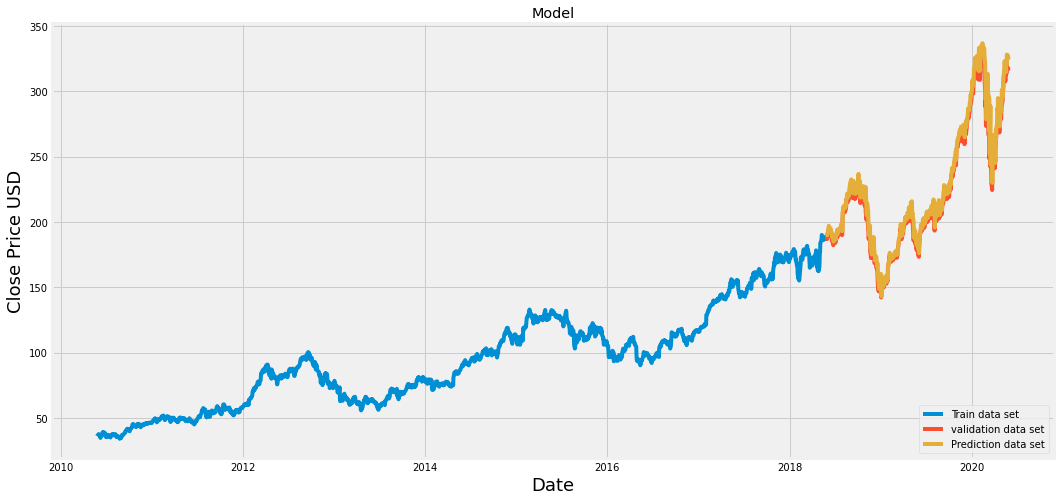

In [ ]:
#Plot data
train = appleclose[:training_apple_data]
valid = appleclose[training_apple_data:]
valid['Predictions'] = applepredictions
#visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize = 18)
plt.ylabel('Close Price USD', fontsize = 18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train data set', 'validation data set','Prediction data set'],loc ='lower right' )
plt.show()

In [ ]:
#show the validation price and predicted price
valid

,Close,Predictions
Date,,
2018-05-29,187.899994,191.499786
2018-05-30,187.500000,190.701401
2018-05-31,186.869995,190.354080
2018-06-01,190.240005,189.685028
2018-06-04,191.830002,193.472900
...,...,...
2020-05-20,319.230011,320.371521
2020-05-21,316.850006,328.019592
2020-05-22,318.890015,324.237305


In [ ]:
#Predict future price
apple_quote = web.DataReader('AAPL', data_source='yahoo', start='2010-05-27', end='2020-07-01')
#Create new dataframe
new_df = apple_quote.filter(['Close'])
#Extract last 90 days closing price and convert df to array
last_360_days = new_df[-360:].values
#scalre the data to be valued between 0 and 1
last_360_days_scaled = scaler.transform(last_360_days)
#create an empty list
X_test = []
#Append past 360 days to empty list
X_test.append(last_360_days_scaled)
#Convert the X_test dataset to a numpy array
X_test = np.array(X_test)
#Reshape data
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
#Get the predicted scaled price
pred_price = model.predict(X_test)
#Undo the scaling
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)

[[374.0173]]


In [ ]:
apple_quote2 = web.DataReader('AAPL', data_source='yahoo', start='2010-05-27', end='2020-07-02')
print(apple_quote2['Close'])


Date
2010-05-27     36.192856
2010-05-28     36.697144
2010-06-01     37.261429
2010-06-02     37.707142
2010-06-03     37.588570
                 ...    
2020-06-26    353.630005
2020-06-29    361.779999
2020-06-30    364.799988
2020-07-01    364.109985
2020-07-02    364.109985
Name: Close, Length: 2543, dtype: float64
